<a href="https://colab.research.google.com/github/ma22asu/Air-Quality-Index-project/blob/main/Air_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Set display options
pd.set_option('display.max_columns', None)


In [2]:
import pandas as pd
import requests
from io import BytesIO
from zipfile import ZipFile

# Step 1: Download and Extract Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
response = requests.get(url)
zip_file = ZipFile(BytesIO(response.content))
csv_filename = "AirQualityUCI.csv"

# Extract and load the CSV file
with zip_file.open(csv_filename) as file:
    data = pd.read_csv(file, sep=';', decimal=',', na_values='-200', low_memory=False)
data.head()


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [3]:
data.dropna(axis=1, how='all', inplace=True)  # Drop completely empty columns

# Step 3: Handle DateTime
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
data.drop(['Date', 'Time'], axis=1, inplace=True)  # Drop original Date and Time columns
data.dropna(subset=['DateTime'], inplace=True)  # Remove rows where DateTime couldn't be parsed

# Step 4: Handle Missing Values
# Drop rows with more than 20% missing values
data.dropna(thresh=int(0.8 * len(data.columns)), inplace=True)

# Fill remaining missing values with column medians
data.fillna(data.median(numeric_only=True), inplace=True)

# Step 5: Reset Index
data.reset_index(drop=True, inplace=True)

# Step 6: Feature Scaling (if required later)
# Identify numerical columns for scaling
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
# Store original column names for analysis later

# Display the cleaned dataset
print("Cleaned Dataset Shape:", data.shape)
print(data.head())

# Step 7: Save Processed Data (Optional)
processed_filename = "processed_air_quality.csv"
data.to_csv(processed_filename, index=False)
print(f"Processed data saved as {processed_filename}.")

Cleaned Dataset Shape: (7796, 14)
   CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0     2.6       1360.0     150.0      11.9         1046.0    166.0   
1     2.0       1292.0     112.0       9.4          955.0    103.0   
2     2.2       1402.0      88.0       9.0          939.0    131.0   
3     2.2       1376.0      80.0       9.2          948.0    172.0   
4     1.6       1272.0      51.0       6.5          836.0    131.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  \
0        1056.0    113.0        1692.0       1268.0  13.6  48.9  0.7578   
1        1174.0     92.0        1559.0        972.0  13.3  47.7  0.7255   
2        1140.0    114.0        1555.0       1074.0  11.9  54.0  0.7502   
3        1092.0    122.0        1584.0       1203.0  11.0  60.0  0.7867   
4        1205.0    116.0        1490.0       1110.0  11.2  59.6  0.7888   

             DateTime  
0 2004-03-10 18:00:00  
1 2004-03-10 19:00:00  
2 2004-03-10 20:00:00 

In [4]:
processed_air_quality = pd.read_csv("processed_air_quality.csv")
processed_air_quality.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00


Summary Statistics:
            CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  7796.000000  7796.000000  7796.000000  7796.000000    7796.000000   
mean      2.110595  1103.733581   153.374808    10.111775     940.374936   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.100000   940.000000   145.000000     4.400000     735.000000   
50%       1.800000  1068.000000   145.000000     8.300000     913.000000   
75%       2.800000  1236.000000   145.000000    14.100000    1120.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   
std       1.396330   217.972359    73.475288     7.415141     266.424936   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  7796.000000   7796.000000  7796.000000   7796.000000  7796.000000   
mean    238.895844    833.622242   111.982555   1444.605952  1032.922781   
min       2.000000    322.000000     2.000000    551.000000   221.0

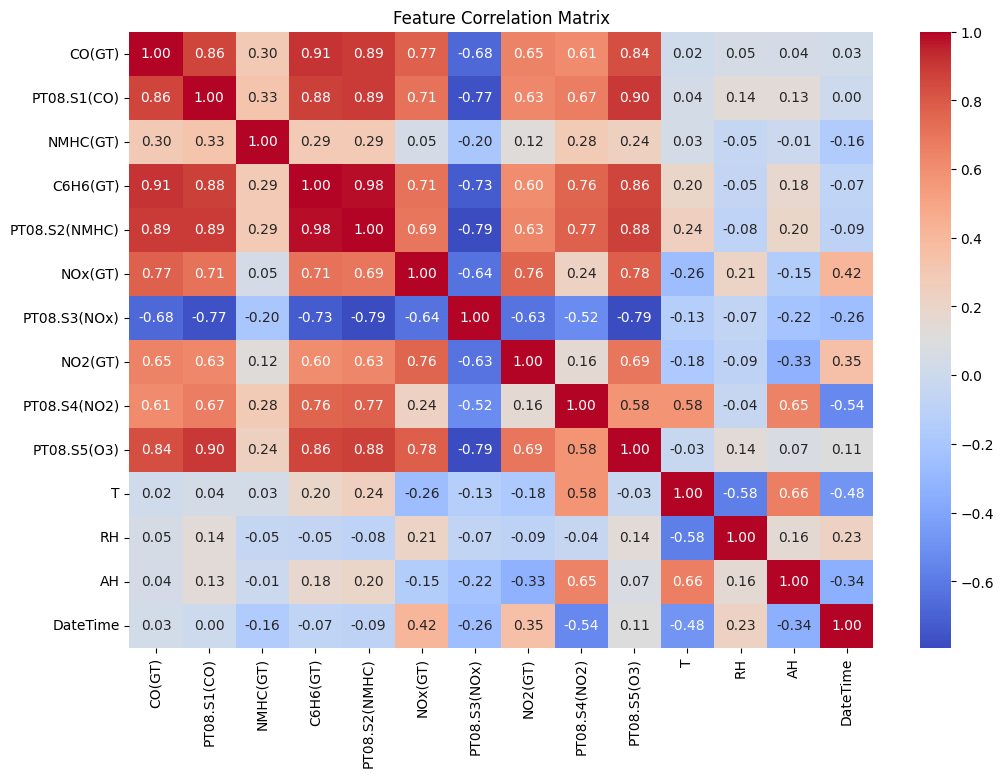

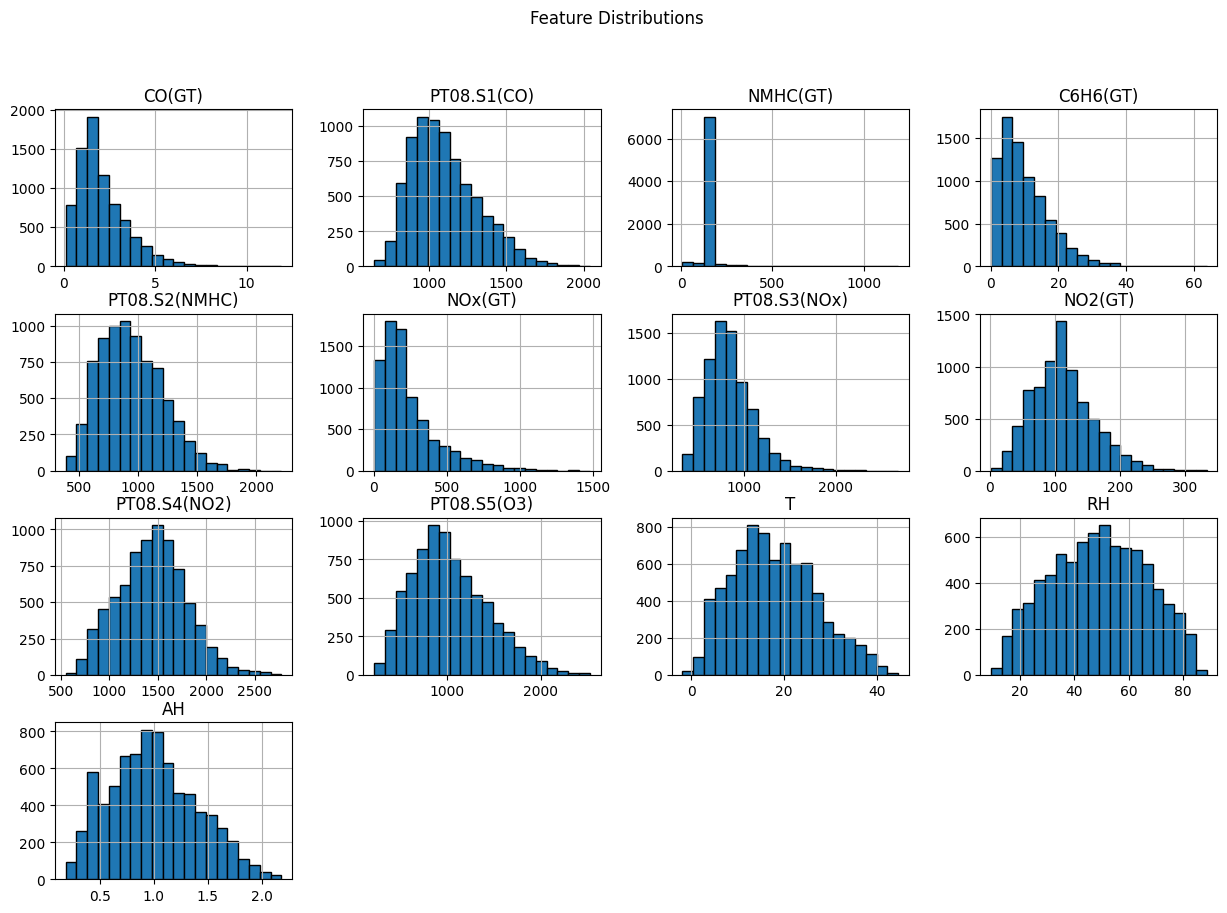

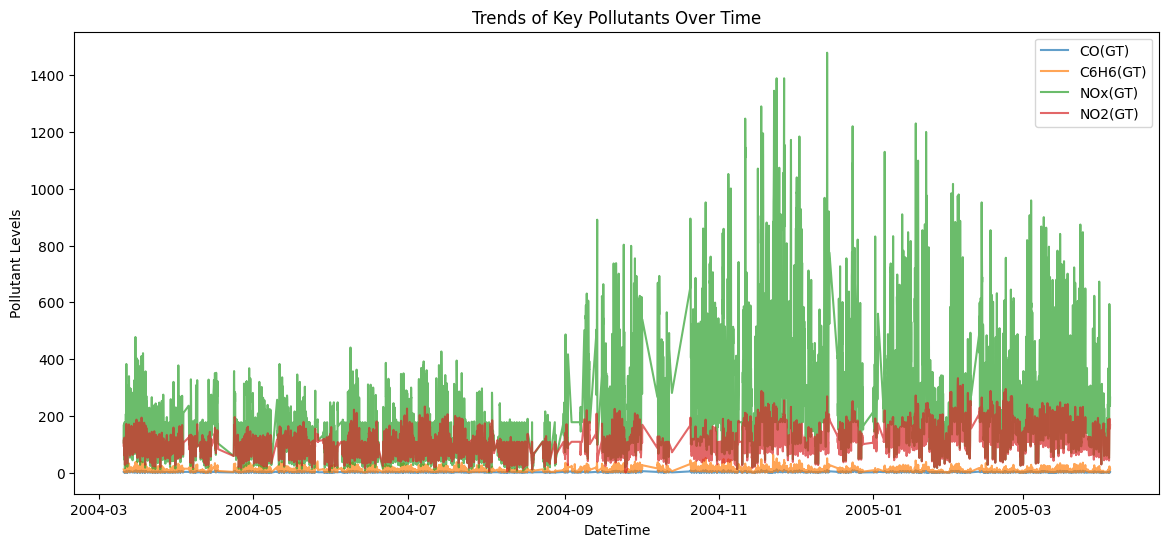

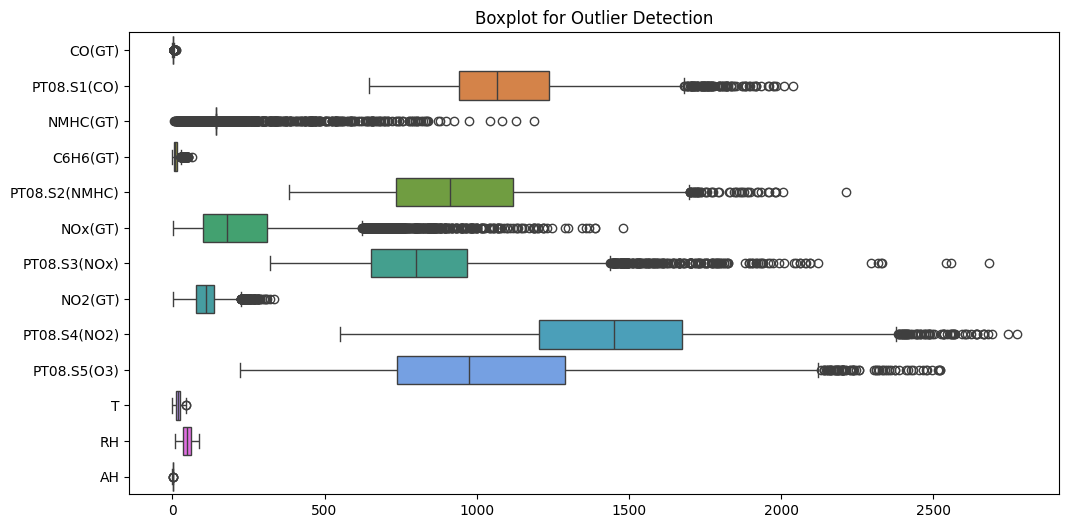

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Summary Statistics
print("Summary Statistics:")
print(data.describe())

# Step 2: Missing Values Analysis
print("\nMissing Values Count:")
print(data.isnull().sum())

# Step 3: Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# Step 4: Feature Distributions
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_columns].hist(figsize=(15, 10), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

# Step 5: Time Series Visualization
plt.figure(figsize=(14, 6))
for column in ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']:
    plt.plot(data['DateTime'], data[column], label=column, alpha=0.7)
plt.xlabel("DateTime")
plt.ylabel("Pollutant Levels")
plt.legend()
plt.title("Trends of Key Pollutants Over Time")
plt.show()

# Step 6: Outlier Detection
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[numerical_columns], orient="h")
plt.title("Boxplot for Outlier Detection")
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'AQI' is the target column (you may need to adjust based on your dataset)
# For this demo, let's assume the 'CO(GT)' column is the target (replace with the actual target column if different)
target_column = 'CO(GT)'  # Replace with the actual target column

# Drop the target column and non-numeric columns from the features
features = data.drop([target_column, 'DateTime'], axis=1)  # Exclude target and non-numeric column
target = data[target_column]  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize MLP Regressor
mlp_regressor = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=500, random_state=42)

# Train the MLP model
mlp_regressor.fit(X_train, y_train)

# Make predictions
y_pred_mlp = mlp_regressor.predict(X_test)

# Evaluate the model
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
rmse_mlp = mse_mlp ** 0.5
r2_mlp = r2_score(y_test, y_pred_mlp)

# Print the evaluation metrics
print(f"MLP Regressor Performance:")
print(f"Mean Squared Error (MSE): {mse_mlp:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_mlp:.2f}")
print(f"R-squared (R2): {r2_mlp:.2f}")


MLP Regressor Performance:
Mean Squared Error (MSE): 1.54
Root Mean Squared Error (RMSE): 1.24
R-squared (R2): 0.21


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Random Forest for Regression
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest Regressor
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_regressor.predict(X_test)

# Evaluate the Random Forest Regressor
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

# Print the regression evaluation metrics
print(f"Random Forest Regressor Performance:")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"R-squared (R2): {r2_rf:.2f}")


Random Forest Regressor Performance:
Mean Squared Error (MSE): 0.18
Root Mean Squared Error (RMSE): 0.42
R-squared (R2): 0.91


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a binary classification target based on AQI threshold
threshold = 50
y_class = (y_train > threshold).astype(int)  # 1 for 'bad', 0 for 'good'
y_class_test = (y_test > threshold).astype(int)

# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_class)

# Make predictions
y_pred_class = rf_classifier.predict(X_test)

# Evaluate the classification model
accuracy_rf = accuracy_score(y_class_test, y_pred_class)
class_report_rf = classification_report(y_class_test, y_pred_class)

# Print the classification evaluation metrics
print(f"Random Forest Classifier Performance:")
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Classification Report:\n{class_report_rf}")


Random Forest Classifier Performance:
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1560

    accuracy                           1.00      1560
   macro avg       1.00      1.00      1.00      1560
weighted avg       1.00      1.00      1.00      1560



In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Verify and create 'CO(GT)_raw' if needed
if 'CO(GT)_raw' not in data.columns:
    if 'CO(GT)' in data.columns:
        data['CO(GT)_raw'] = data['CO(GT)'] * data['CO(GT)'].std() + data['CO(GT)'].mean()
    else:
        raise KeyError("'CO(GT)' column is missing; cannot create 'CO(GT)_raw'.")

# Define features and target
features = ['PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
            'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
X = data[features]
y_class = (data['CO(GT)_raw'] > data['CO(GT)_raw'].median()).astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=2000)
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the Logistic Regression model
accuracy_log_reg = accuracy_score(y_test, y_pred)
class_report_log_reg = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f"Logistic Regression Classifier Performance (After Scaling):")
print(f"Accuracy: {accuracy_log_reg:.2f}")
print(f"Classification Report:\n{class_report_log_reg}")


Logistic Regression Classifier Performance (After Scaling):
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       817
           1       0.91      0.93      0.92       743

    accuracy                           0.92      1560
   macro avg       0.92      0.92      0.92      1560
weighted avg       0.92      0.92      0.92      1560



In [10]:
# Check the distribution of the target variable (y_class)
y_class.value_counts()


,count
CO(GT)_raw,
0,4214
1,3582


In [11]:
# Adjust the threshold for binary classification (AQI > 100 for 'good', else 'bad')
y_class = (data['CO(GT)'] > 100).astype(int)

# Verify the class distribution again
print(y_class.value_counts())


CO(GT)
0    7796
Name: count, dtype: int64


In [12]:
# Check the distribution of CO(GT)
data['CO(GT)'].describe()


,CO(GT)
count,7796.000000
mean,2.110595
std,1.396330
min,0.100000
25%,1.100000
50%,1.800000
75%,2.800000
max,11.900000


In [13]:
# Using unscaled CO(GT) values for classification
data['CO(GT)_raw'] = data['CO(GT)'] * data['CO(GT)'].std() + data['CO(GT)'].mean()  # Reverting scaling

# Set the threshold for binary classification (e.g., CO(GT) > 2 as 'good' air quality)
y_class = (data['CO(GT)_raw'] > 2).astype(int)

# Check class distribution
print(y_class.value_counts())


CO(GT)_raw
1    7796
Name: count, dtype: int64


In [14]:
# Adjusting the threshold for classification (e.g., CO(GT) > 1)
threshold = 1
y_class = (data['CO(GT)_raw'] > threshold).astype(int)

# Check new class distribution
print(y_class.value_counts())


CO(GT)_raw
1    7796
Name: count, dtype: int64


In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Randomized Search with 50 iterations
rf_model = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter combinations to try
    scoring='accuracy',
    cv=3,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}
Best Cross-Validation Accuracy: 0.9267160969117979


In [16]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Initialize Random Forest with best parameters
best_rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=20,
    bootstrap=True,
    random_state=42
)

# Train on the full training set
best_rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Print evaluation metrics
print(f"Random Forest Classifier Performance (Tuned):")
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Classification Report:\n{class_report_rf}")

# Save the trained Random Forest model
joblib.dump(best_rf_model, "random_forest_classifier.pkl")
print("Random Forest model saved as 'random_forest_classifier.pkl'.")


Random Forest Classifier Performance (Tuned):
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       817
           1       0.91      0.95      0.93       743

    accuracy                           0.93      1560
   macro avg       0.93      0.93      0.93      1560
weighted avg       0.93      0.93      0.93      1560

Random Forest model saved as 'random_forest_classifier.pkl'.


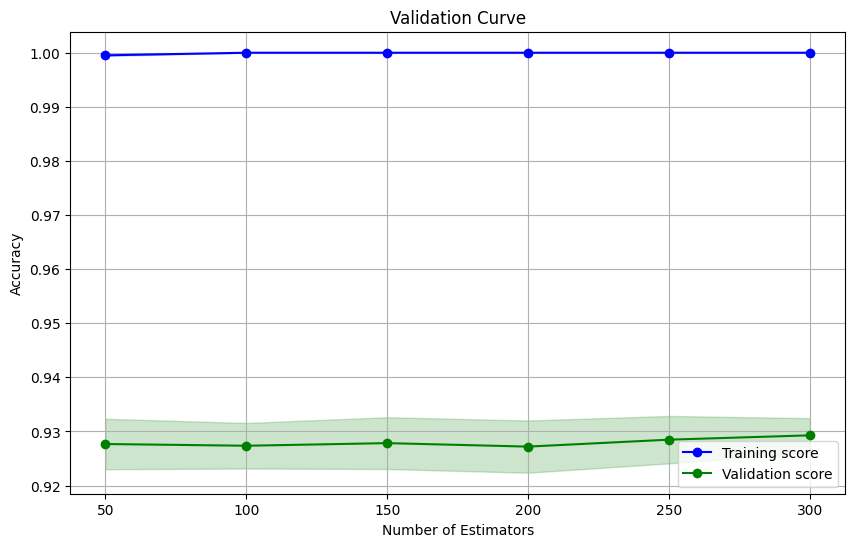

In [17]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Validation Curve for Random Forest
param_range = [50, 100, 150, 200, 250, 300]
train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot Validation Curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Validation score", color="green", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)
plt.title("Validation Curve")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


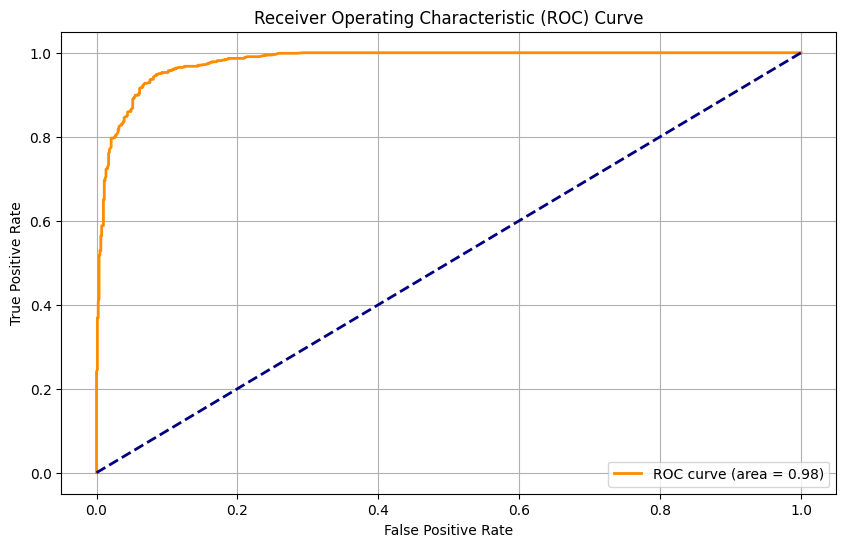

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


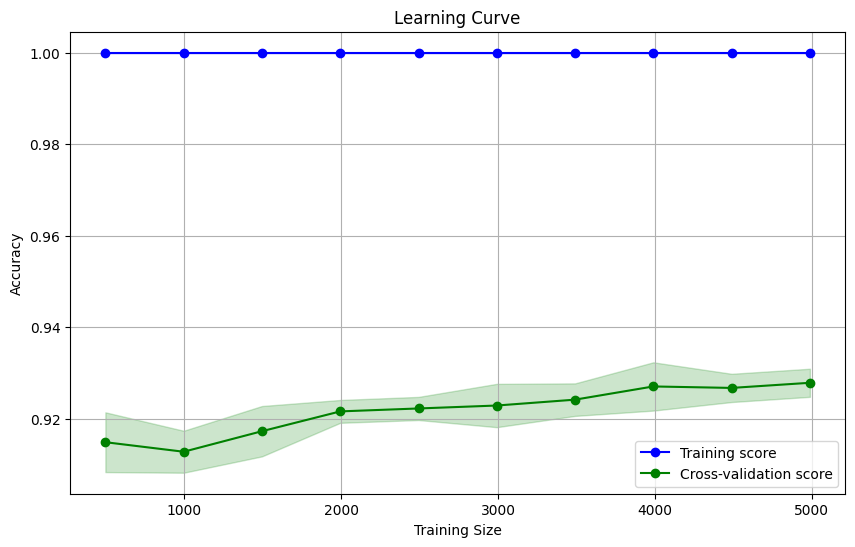

In [19]:
from sklearn.model_selection import learning_curve

# Generate Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(random_state=42, n_estimators=300, max_depth=20),
    X_train,
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="green", marker="o")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


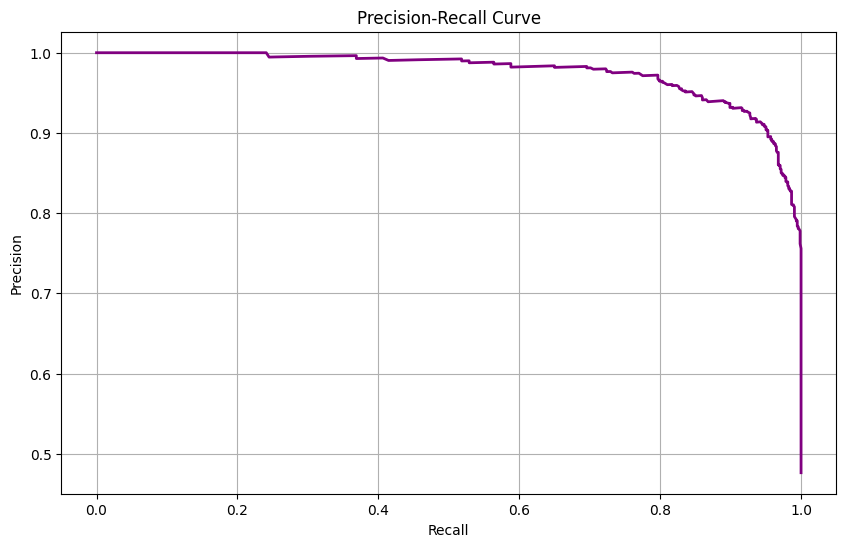

In [20]:
from sklearn.metrics import precision_recall_curve

# Predict probabilities
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color="purple", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()


Dataset columns: Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'DateTime', 'CO(GT)_raw'],
      dtype='object')
Random Forest Classifier Performance (Tuned):
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       817
           1       0.91      0.95      0.93       743

    accuracy                           0.93      1560
   macro avg       0.93      0.93      0.93      1560
weighted avg       0.93      0.93      0.93      1560



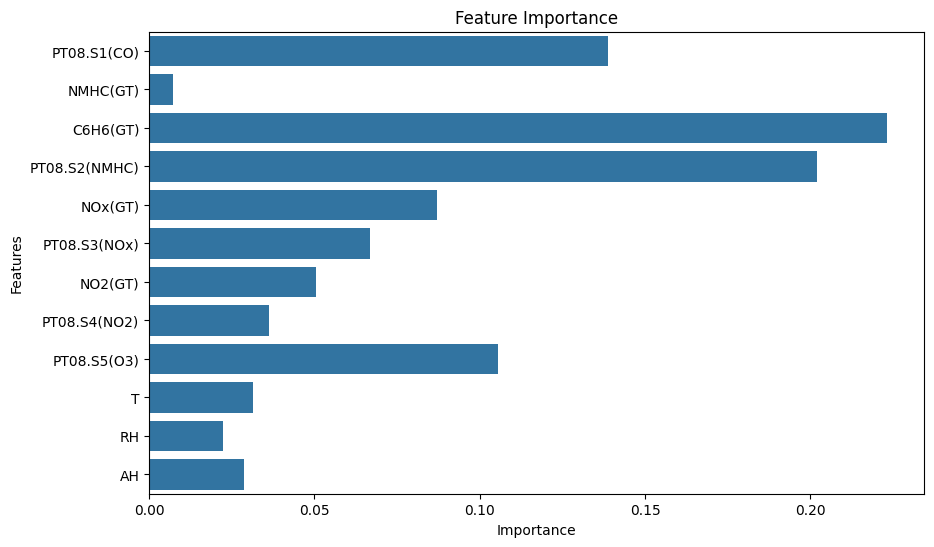

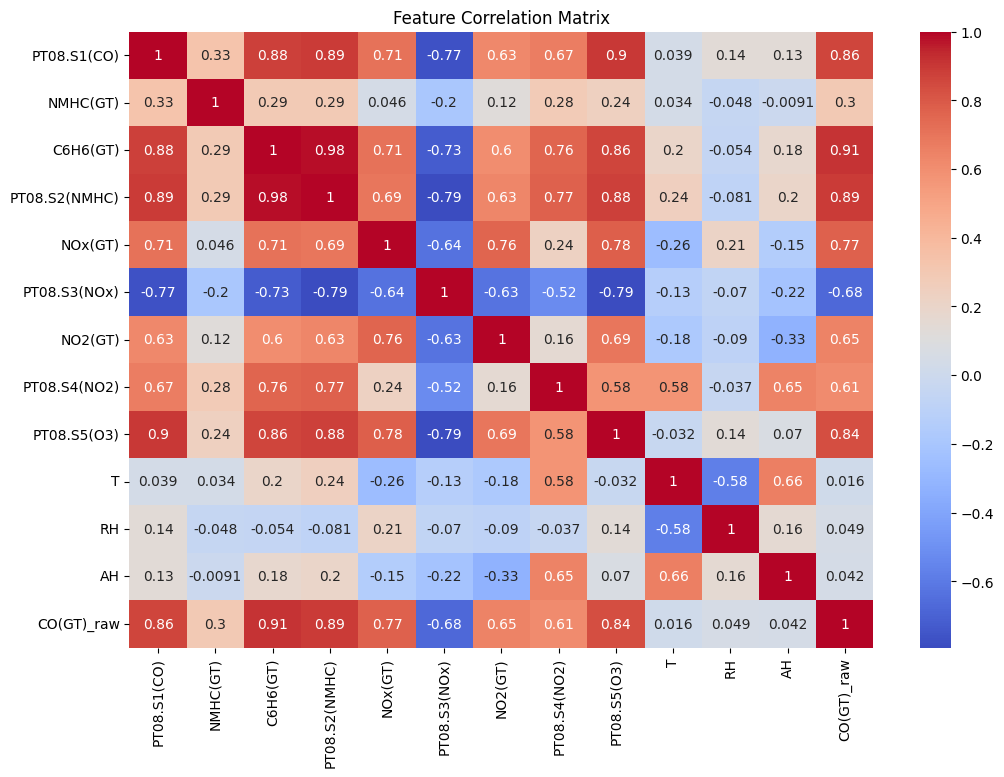

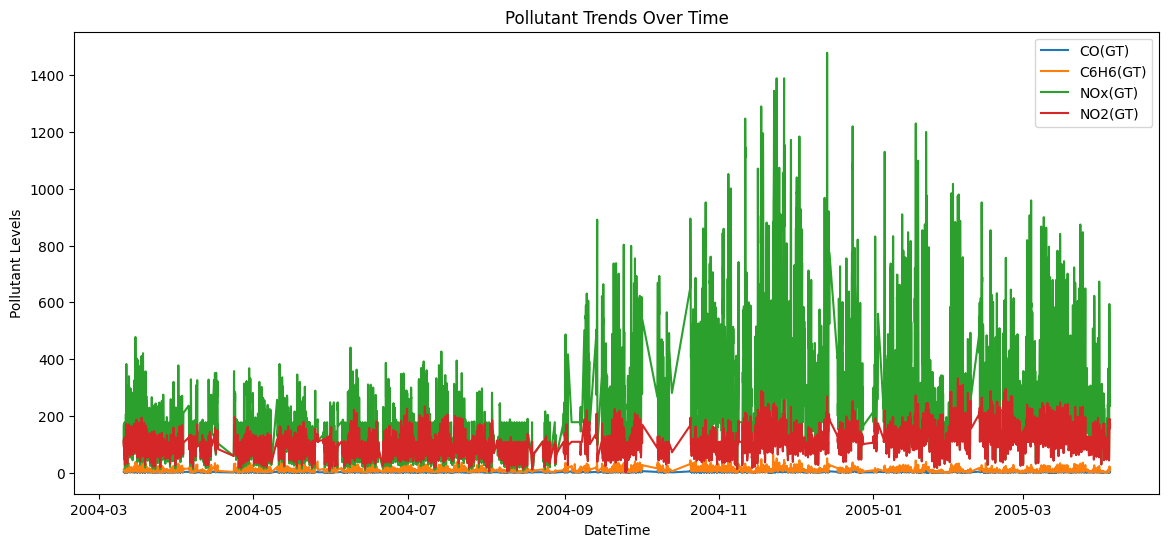

In [21]:
# Verify or recreate 'CO(GT)_raw'
if 'CO(GT)_raw' not in data.columns:
    if 'CO(GT)' in data.columns:
        # Recreate 'CO(GT)_raw' based on provided transformation logic
        data['CO(GT)_raw'] = data['CO(GT)'] * data['CO(GT)'].std() + data['CO(GT)'].mean()
        print("'CO(GT)_raw' column created successfully.")
    else:
        raise KeyError("Column 'CO(GT)' not found in the dataset to create 'CO(GT)_raw'.")

# Confirm the available columns
print("Dataset columns:", data.columns)

# Define binary target variable
y_class = (data['CO(GT)_raw'] > data['CO(GT)_raw'].median()).astype(int)

# Define the feature set
features = ['PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
            'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
X = data[features]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Train the best Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=20,
    bootstrap=True,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Print evaluation metrics
print(f"Random Forest Classifier Performance (Tuned):")
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Classification Report:\n{class_report_rf}")

# Feature importance visualization
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data[features + ['CO(GT)_raw']].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# Time series trends
if 'DateTime' in data.columns:
    pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
    plt.figure(figsize=(14, 6))
    for pollutant in pollutants:
        if pollutant in data.columns:
            plt.plot(data['DateTime'], data[pollutant], label=pollutant)
    plt.xlabel("DateTime")
    plt.ylabel("Pollutant Levels")
    plt.legend()
    plt.title("Pollutant Trends Over Time")
    plt.show()
else:
    print("Column 'DateTime' not found; skipping time series visualization.")


      PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  \
2926        774.0     145.0       1.9          577.0     21.0        1158.0   
5502       1293.0     145.0      14.6         1136.0    542.0         631.0   
2809       1075.0     145.0       9.9          973.0     79.0         695.0   
1025        948.0     145.0       4.8          754.0     64.0        1086.0   
101        1239.0      66.0       7.4          872.0    104.0         985.0   

      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH Actual AQI  \
2926     33.0        1265.0        488.0  23.9  34.4  1.0079       Good   
5502    170.0        1365.0       1278.0   5.2  83.1  0.7411        Bad   
2809     74.0        1748.0       1231.0  26.4  44.5  1.5119       Good   
1025     64.0        1436.0        602.0  24.4  32.7  0.9863       Good   
101      99.0        1547.0       1250.0  14.8  54.7  0.9164       Good   

     Predicted AQI  
2926          Good  
5502           Bad  
2809       

<ipython-input-22-d2bbaef4f267>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y_pred_labels, palette="coolwarm")


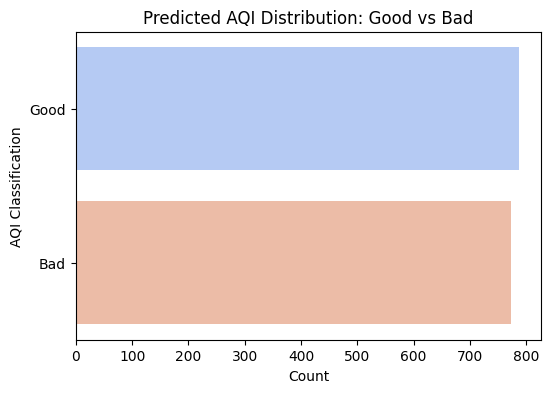

In [22]:
# Map predictions to "Good" or "Bad"
y_pred_labels = ["Good" if pred == 0 else "Bad" for pred in y_pred_rf]

# Add predictions to the test dataset for reference
X_test_with_predictions = X_test.copy()
X_test_with_predictions['Actual AQI'] = ["Good" if actual == 0 else "Bad" for actual in y_test]
X_test_with_predictions['Predicted AQI'] = y_pred_labels

# Display the first few rows of the predictions
print(X_test_with_predictions.head())

# Count "Good" and "Bad" predictions
print("Predicted AQI Distribution:")
print(pd.Series(y_pred_labels).value_counts())

# Visualize the distribution of "Good" vs "Bad"
plt.figure(figsize=(6, 4))
sns.countplot(y=y_pred_labels, palette="coolwarm")
plt.title("Predicted AQI Distribution: Good vs Bad")
plt.xlabel("Count")
plt.ylabel("AQI Classification")
plt.show()
